In [155]:
import xarray as xr
import matplotlib.pyplot as plt
import saildrone_processing
from front_detection import detect_grad_1d
from front_detection import match_obs_alt
import functions
import numpy as np
import pandas as pd
from functions import import_cmems
import matplotlib as mpl

## Importing Saildrone data

In [2]:
ds_saildrone = xr.open_mfdataset("~/shared/antarctic_sd_data/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc", chunks='auto')

In [140]:
variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

# gdf = saildrone_processing.prepare_data(ds_saildrone, variables, aggregate_method='mean', 
#                                         resample_to='1440Min')
gdf = saildrone_processing.prepare_data(ds_saildrone, variables, aggregate_method='mean', 
                                        resample_to='720Min')

In [106]:
lat_sdrn  = gdf.latitude
lon_sdrn  = gdf.longitude
time_sdrn = gdf.time

## Importing the variable from CMEMS

In [ ]:
# Importing the variable from CMEMS
# Remember that once the credentials are used, you will need to change your password at CMEMS
# it is a bug to be solved in this function
# var = import_cmems('adt', 
#       'https://my.cmems-du.eu/thredds/dodsC/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D', 
#       'fsilva3', '', -180, 180, -65, -45, '2019-01-01', '2020-01-01')

## Below, we select the positions of the in situ observation that matches with the peaks in the SSH gradient

--> It will return the regions where the in situ observations lie within or outside mesoscale fronts

In [115]:
def match_obs_alt(altimeter, lon_sdrn, lat_sdrn, threshold = 2*1e-6):
    ''' Match the position of the peaks in SSH grad with the position of the in situ observation
    Writers: Felipe Vilela da Silva and Alessio Arena
    ==============================================================================
    INPUTS:
    
    OUTPUTS:
    '''
    
    if ~np.isnan(lat_sdrn):
        ## Next, I extract the altimeter information nearby the in situ observation
        alt_at_obs = altimeter.sel(latitude = slice(lat_sdrn-1, lat_sdrn+1), 
                                   longitude = slice(lon_sdrn-1,lon_sdrn+1))

        # TODO: if interested, find a more accurate way to convert deg to m
        # we have first followed the latitudinal and longitudinal distances but it only worked
        # if we turned the xarray into a np.array. We preferred to keep it as a xarray atm.
        deg_to_m = 111195.
        var_x = alt_at_obs.differentiate('longitude')/deg_to_m
        var_y = alt_at_obs.differentiate('latitude')/deg_to_m
        ## Below, I compute the module of the gradient 
        gradient = np.sqrt(var_x**2 + var_y**2)

        grad_thld   = gradient.where(gradient > threshold)
        grad_at_obs = grad_thld.sel(latitude=lat_sdrn.data, longitude=lon_sdrn.data, 
                                    method = 'nearest').data.item()
    
        return ~np.isnan(grad_at_obs)
    else:
        return False

In [124]:
# %time
# bol_pos = np.ravel([np.array(match_obs_alt(var.sel(time=str(time_sdrn[t]), method = 'nearest'), 
#                     lon_sdrn[t], lat_sdrn[t])) for t in range(len(lon_sdrn))])

### Then, we look for gradients in the in situ observations within the mesoscale front
--> It will return the regions where the in situ observations captured smaler scale fronts

In [157]:
gdf_gradSSH = gdf.loc[bol_pos].copy()
gdf_nogradSSH = gdf.loc[~bol_pos].copy()

In [147]:
distance = functions.distFromStart(gdf_gradSSH.latitude.values, gdf_gradSSH.longitude.values)
gdf_gradSSH['distance_km'] = distance

In [152]:
# input the data variable that you want to find fronts with
var = 'TEMP_CTD_RBR_MEAN'

# TO DO: Discuss what criterion we should use for different variables.
# criterion = [0.01, 0.05, 0.25, 0.75, 1] 
criterion = [0, 0.001, 0.0025, 0.005, 0.01] 

temp_fronts = detect_grad_1d(gdf_gradSSH, var, criterion, x_bin = 500, min_obs = False)

(-180.0, 180.0)

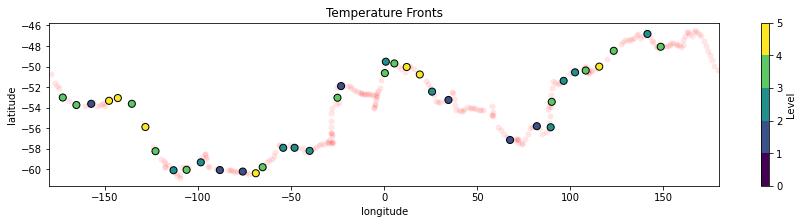

In [190]:
fig, ax = plt.subplots(figsize = (15,3))

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(np.arange(0, len(criterion)+1, 1), cmap.N)

plt.scatter(gdf_nogradSSH.longitude, gdf_nogradSSH.latitude, c = 'r', label = 'no SSH grad', alpha = .1,
            edgecolors = 'w')
plt.scatter(temp_fronts.longitude, temp_fronts.latitude, c = temp_fronts.level, norm = norm, s = 50,
            edgecolors = 'k')

# CS = mean_sea_level.plot.contour(colors = 'dimgrey', alpha = 0.5, linewidths = 1.2, levels = adt_levels)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'Level', ticks = np.arange(0, len(criterion)+1, 1))
plt.title('Temperature Fronts')
plt.xlim(-180,180)